In [ ]:
# default_exp funcs.plotting

In [ ]:
%load_ext autoreload
%autoreload 2

# Plottings functions

In [ ]:
#export
from decode_fish.imports import *
from mpl_toolkits import axes_grid1
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from decode_fish.funcs.utils import *
from decode_fish.funcs.emitter_io import *

In [ ]:
#export
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """ Add a vertical color bar to an image plot """

    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

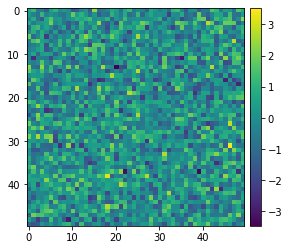

In [ ]:
im = plt.imshow(np.random.normal(size=[50,50]))
add_colorbar(im)

In [ ]:
#export
def sl_plot(x, xsim, pred_df, target_df, background, res):
    
    pred_df = pred_df[pred_df['frame_idx']==0]
    target_df = target_df[target_df['frame_idx']==0]
    with torch.no_grad():
        fig = plt.figure(figsize=(20,4))
        plt.subplot(151)
        im = plt.imshow(x[0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Real image')

        plt.subplot(152)
        im = plt.imshow(xsim[0][0].cpu().numpy().max(0))
        plt.scatter(target_df['x'], target_df['y'],facecolors='black', edgecolors='black', marker='x', s=25.)
        plt.scatter(pred_df['x'], pred_df['y'],facecolors='red', edgecolors='red', marker='o', s=5.)
        add_colorbar(im)
        plt.axis('off')
        plt.title('Sim. image')

        plt.subplot(153)
        im = plt.imshow(torch.sigmoid(res['logits'][0][0]).cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Predicted locations')

        plt.subplot(154)
        im = plt.imshow(background[0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Background')

        plt.subplot(155)
        im = plt.imshow(res['background'][0][0].cpu().numpy().max(0))
        add_colorbar(im)
        plt.axis('off')
        plt.title('Predicted background')

    return fig

def gt_plot(x, pred_df, gt_df, px_size, gt_rec=None, psf=None, fig_size=(24,6)):

    with torch.no_grad():
        fig = plt.figure(figsize=fig_size)
        plt.subplot(141)
        
        x = x[0].cpu().numpy()
        
        max_proj = x.max(0)
        vmax = max_proj.max()
        im = plt.imshow(max_proj, vmax=vmax)
        add_colorbar(im)
        plt.scatter(pred_df['x'], pred_df['y'],facecolors='red', edgecolors='red', marker='+', s=20)
#         plt.scatter(gt_df['x'], gt_df['y'],facecolors='none', edgecolors='black', marker='o', s=20)
        plt.axis('off')
        plt.title('Real image')
        
        if gt_rec is not None:
            
            gt_rec = gt_rec[0].cpu().numpy()
        
            plt.subplot(142)
            im = plt.imshow(gt_rec.max(0), vmax=vmax)
            add_colorbar(im)
            plt.axis('off')
            plt.title('RMSE ' + str(np.round(np.sqrt(((x-gt_rec)**2).mean()),2)))
            
            plt.subplot(143)
            im = plt.imshow(abs(x - gt_rec).max(0))
            add_colorbar(im)
            plt.axis('off')
            
            if psf is not None:
                plt.subplot(144)
                im = plt.imshow(psf.psf_volume[0].detach().cpu().numpy().mean(1))
                plt.axis('off')
    
    return fig

def plot_3d_projections(volume, projection='mean', size=6, vmax=None):

    if torch.is_tensor(volume):
        plot_vol = volume.detach().cpu().numpy()
    else:
        plot_vol = volume
        
    fig, axes = plt.subplots(1,3, figsize=(3*size, size))
    for i in range(3):
        if 'mean' in projection:
            im = axes[i].imshow(plot_vol.mean(i),vmax=vmax)
        if 'max' in projection:
            im = axes[i].imshow(plot_vol.max(i),vmax=vmax)
        if 'min' in projection:
            im = axes[i].imshow(plot_vol.min(i),vmax=vmax)
        add_colorbar(im)
        
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('z')
    axes[2].set_xlabel('y')
    axes[2].set_ylabel('z')

    return axes

def scat_3d_projections(axes, dfs, px_size_zyx=[1.,1.,1], s_fac=1.):
    colors = ['red','black','orange']
    markers = ['o','+','x']
    if not isinstance(dfs, list):
        dfs = [dfs]
    for i,df in enumerate(dfs):
        df = nm_to_px(df, px_size_zyx)
        axes[0].scatter(df['x'],df['y'], color=colors[i], marker=markers[i], s=20*s_fac, label=f'DF {i}')
        axes[1].scatter(df['x'],df['z'], color=colors[i], marker=markers[i], s=20*s_fac)
        axes[2].scatter(df['y'],df['z'], color=colors[i], marker=markers[i], s=20*s_fac)
    axes[0].legend()
    
def plot_prob_hist(res_dict):
    fig = plt.figure()
    plt.hist(cpu(torch.sigmoid(res_dict['logits'])).reshape(-1), bins=np.linspace(0.01,1,100))
    return fig

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
